In [11]:
import os
import warnings

# Prevent MKL KMeans warning
os.environ['OMP_NUM_THREADS'] = '1'

# Suppress all sklearn-related warnings
warnings.filterwarnings("ignore", category=UserWarning)


In [12]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.base import BaseEstimator, ClusterMixin


In [13]:
# Load the dataset
df = pd.read_csv("Mall_Customers.csv")

# Display first few rows
print(df.head())

   CustomerID   Genre  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40


In [14]:
# Data Preprocessing
# Selecting relevant features: Annual Income and Spending Score
X = df[['Annual Income (k$)', 'Spending Score (1-100)']]

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

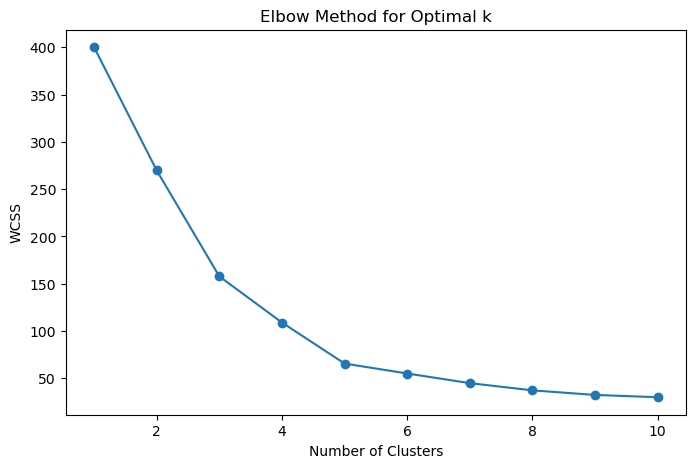

In [15]:
# -------------------------------
# KMeans Clustering
# -------------------------------
# Find optimal k using Elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plotting Elbow Curve
plt.figure(figsize=(8,5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

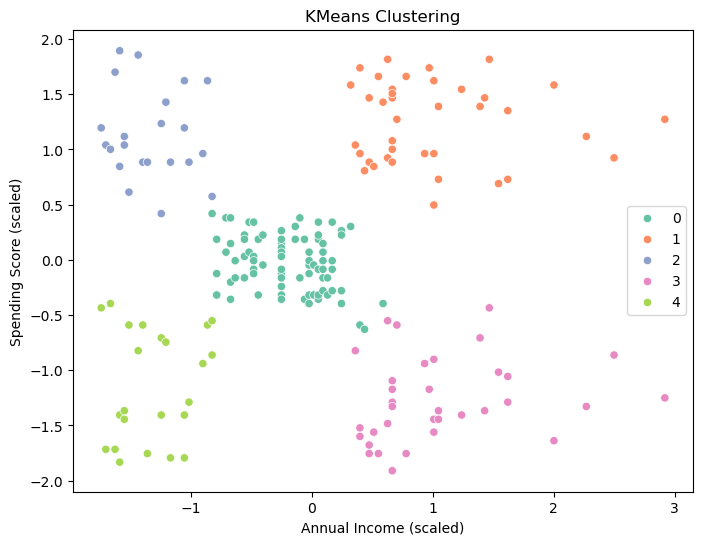

Silhouette Score (KMeans): 0.555


In [16]:
# Apply KMeans with optimal k (say k=5)
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Add to original DataFrame
df['KMeans_Cluster'] = kmeans_labels

# Visualize KMeans Clustering
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=kmeans_labels, palette='Set2')
plt.title("KMeans Clustering")
plt.xlabel("Annual Income (scaled)")
plt.ylabel("Spending Score (scaled)")
plt.show()

# Silhouette Score for KMeans
kmeans_score = silhouette_score(X_scaled, kmeans_labels)
print(f"Silhouette Score (KMeans): {kmeans_score:.3f}")

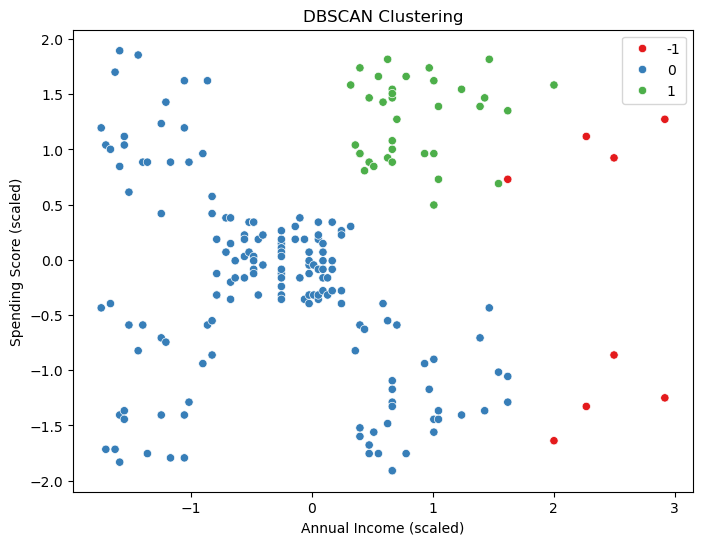

Silhouette Score (DBSCAN): 0.388


In [17]:
# -------------------------------
# DBSCAN Clustering
# -------------------------------
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

# Add to DataFrame
df['DBSCAN_Cluster'] = dbscan_labels

# Visualize DBSCAN Clustering
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=dbscan_labels, palette='Set1')
plt.title("DBSCAN Clustering")
plt.xlabel("Annual Income (scaled)")
plt.ylabel("Spending Score (scaled)")
plt.show()

# Silhouette Score for DBSCAN (exclude -1: noise)
mask = dbscan_labels != -1
if len(set(dbscan_labels)) > 1 and np.any(mask):
    dbscan_score = silhouette_score(X_scaled[mask], dbscan_labels[mask])
    print(f"Silhouette Score (DBSCAN): {dbscan_score:.3f}")
else:
    print("DBSCAN couldn't find meaningful clusters.")

In [18]:
# -------------------------------
# Cross Validation (for KMeans)
# -------------------------------

class KMeansWrapper(BaseEstimator, ClusterMixin):
    def __init__(self, n_clusters=5):
        self.n_clusters = n_clusters
        self.model = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)

    def fit(self, X, y=None):
        self.model.fit(X)
        return self

    def predict(self, X):
        return self.model.predict(X)

    def fit_predict(self, X, y=None):
        return self.model.fit_predict(X)

# Perform manual cross-validation with Silhouette Score
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

for train_index, test_index in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    model = KMeansWrapper(n_clusters=5)
    labels = model.fit_predict(X_train)
    score = silhouette_score(X_train, labels)
    cv_scores.append(score)

print("Cross-Validation Silhouette Scores (KMeans):", np.round(cv_scores, 3))
print("Average Silhouette Score:", np.mean(cv_scores).round(3))

Cross-Validation Silhouette Scores (KMeans): [0.551 0.561 0.559 0.548 0.552]
Average Silhouette Score: 0.554
